In [1]:
import seaborn
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski

from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics

import pandas as pd
import molvs
import csv
from pprint import pprint

TODO: stahnout data jen pro EC50 a IC50 a vynest je proti pozadi a proti sobe

# Reading the data

In [2]:
CB1_data = []
with open("CB1_cannabinoid_receptor.csv") as f:
    reader = csv.reader(f, delimiter = ";", quotechar = '"')
    for line in reader:
        #print(line)
        CB1_data.append(line)
header = CB1_data[0]
CB1_data = CB1_data[1:]
CB1_data[0]

['CCCCC1=NN(CC1c2ccsc2)C(=O)NC(C)(C)c3ccccc3',
 'EC50',
 '39.81',
 '7.4',
 '369.53',
 '5.34']

In [80]:
CB1_smiles_measure_value = [[r[0], r[1], r[3]] for r in CB1_data]
CB1_smiles_measure_value[:5], len(CB1_smiles_measure_value)

([['CCCCC1=NN(CC1c2ccsc2)C(=O)NC(C)(C)c3ccccc3', 'EC50', '7.4'],
  ['Cl.COc1cccc2c(cn(CC3CCCCC3)c12)C(=O)N4CCN5CCC[C@H]5C4', 'EC50', '7.7'],
  ['CCCCCOc1ccc(C(=O)c2cccc3ccccc23)c4ccccc14', 'EC50', '8.21'],
  ['Cc1ccc(cc1S(=O)(=O)N2CCCCC2)C(=O)Oc3cccc4cccnc34', 'EC50', '8'],
  ['CC(C)NC(=O)c1cc(c2ccc(Cl)cc2)c(nc1Oc3ccc(F)c(F)c3)c4ccc(Cl)cc4Cl',
   'IC50',
   '8.46']],
 1384)

In [81]:
CB1_mols = [Chem.MolFromSmiles(s) for s, m, v in CB1_smiles_measure_value if s]
CB1_measure = [m for s, m, v in CB1_smiles_measure_value if s]
CB1_value = [v for s, m, v in CB1_smiles_measure_value if s]
CB1_mols[:5], len(CB1_mols), CB1_measure[:5], len(CB1_measure), CB1_value[:5], len(CB1_value)

([<rdkit.Chem.rdchem.Mol at 0x7f3d5ad54d00>,
 1301,
 ['EC50', 'EC50', 'EC50', 'EC50', 'IC50'],
 1301,
 ['7.4', '7.7', '8.21', '8', '8.46'],
 1301)

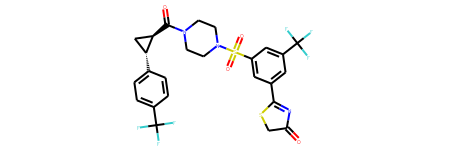

In [5]:
CB1_mols[666]

In [6]:
ZINC_smiles = []
with open("zincs1000.smi") as f:
    for line in f:
        ZINC_smiles.append(line.strip("\n"))

ZINC_smiles[:5]

['CN(C)CC(=O)NCc1cccc(OCc2ccccc2)c1',
 'CSCCN1CCC(C(=O)c2ccc3c(c2)NC(=O)C(C)O3)CC1',
 'CC(=O)N1CCCCC1C(=O)NC1CCCN(c2ncccn2)C1',
 'CNC(=O)C1(C)CCN(C(=O)c2csc(-c3cnn(-c4ccccc4)c3)n2)C1',
 'Fc1ccc2nc(-c3cccc(Cl)c3)sc2c1']

In [7]:
ZINC_mols = [Chem.MolFromSmiles(s) for s in ZINC_smiles if s]
ZINC_mols[0], len(ZINC_mols)

(<rdkit.Chem.rdchem.Mol at 0x7f3d6a4c1490>, 1000)

# Standardization

In [8]:
isOrganic = Chem.MolFromSmarts('[#6]')
hasInorganic = Chem.MolFromSmarts('[!#6;!#7;!#8;!#16;!Cl;!F;!Br;!I]')

_s = molvs.Standardizer()
def standardisation(mol):
    mol = _s.standardize(mol)
    mol = _s.fragment_parent(mol)
    if mol.HasSubstructMatch(isOrganic) and not mol.HasSubstructMatch(hasInorganic):
        mol = _s.charge_parent(mol)
        mol = _s.stereo_parent(mol)
        return mol
    else:
        return None

In [9]:
CB1_supp = (standardisation(mol) for mol in CB1_mols if mol)
CB1_clean = [mol for mol in CB1_supp if mol]
len(CB1_clean)

1301

In [10]:
ZINC_supp = (standardisation(mol) for mol in ZINC_mols if mol)
ZINC_clean = [mol for mol in ZINC_supp if mol]
len(ZINC_clean)

1000

# Descriptors

I'll be using TPSA and clogP for the visulization of my compounds against ZINC compounds.

I'll first show all of the compounds against the ZINC background and then I'll highlight which of my compounds have measured IC50 and EC50.

In [11]:
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from matplotlib import pyplot as plt

In [17]:
CB1_descriptors = [[Descriptors.MolLogP(m), rdMolDescriptors.CalcTPSA(m), True] for m in CB1_clean]
CB1_descriptors = pd.DataFrame(CB1_descriptors, columns = ["cLogP", "TPSA", "isCB1"])
CB1_descriptors["measure"] = CB1_measure

In [34]:
ZINC_descriptors = [[Descriptors.MolLogP(m), rdMolDescriptors.CalcTPSA(m), False] for m in ZINC_clean]
ZINC_descriptors = pd.DataFrame(ZINC_descriptors, columns = ["cLogP", "TPSA", "isCB1"])
ZINC_descriptors["measure"] = ["ZINC" for m in ZINC_clean]

In [35]:
all_descriptors = pd.concat([ZINC_descriptors, CB1_descriptors])

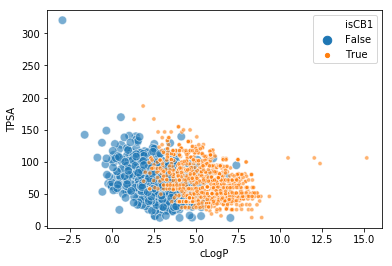

In [46]:
seaborn.scatterplot(data=all_descriptors, x="cLogP", y="TPSA", hue="isCB1", alpha=0.6, size="isCB1")


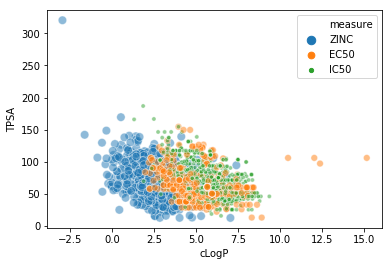

In [37]:
seaborn.scatterplot(data=all_descriptors, x="cLogP", y="TPSA", hue="measure", alpha=0.5, size="measure")


# PCA

In [52]:
lip_func = [Lipinski.NumHAcceptors, Lipinski.NumHDonors, Descriptors.ExactMolWt, Descriptors.MolLogP,
            rdMolDescriptors.CalcTPSA, Lipinski.NumRotatableBonds]
CB1_ro5 = [[f(mol) for f in lip_func] for mol in CB1_clean]

In [60]:
CB1_scaled = preprocessing.scale(CB1_ro5)
pca = decomposition.PCA(n_components=6)
pca.fit(CB1_scaled)
CB1_t = pd.DataFrame(pca.transform(CB1_scaled), columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"])
CB1_t["measure"] = CB1_measure

           PC1       PC2       PC3       PC4       PC5       PC6 measure
0    -1.430807 -0.966766  0.864989  0.451423 -0.181754  0.122586    EC50
1    -1.800062 -1.273533 -0.922099  0.710100 -0.093415 -0.302342    EC50
2    -2.647991  0.094719  1.043595  1.388864  0.039859  0.505604    EC50
3    -0.503123 -1.443255 -1.541774  0.437599  0.064180  0.548040    EC50
4    -0.822876  2.193887  0.734101 -0.185823  0.146573  0.105248    IC50
5    -1.272892 -0.278071 -0.942251  0.210291  1.130793 -0.206340    EC50
6     1.440859  0.068866 -1.216639 -0.406311  1.016253 -0.199088    IC50
7    -1.761450 -1.309910 -1.004822  0.034755  0.779374  0.115093    EC50
8    -2.980731 -0.458656  0.827493  1.182594 -0.067086  0.375085    EC50
9    -1.301299  0.576020  1.632773  0.836595  0.474198 -0.128630    IC50
10   -1.316197  0.170231  1.606952  0.911254  0.507008 -0.176744    IC50
11   -1.230939  0.798808  1.592795  0.798366  0.545994 -0.205335    IC50
12    0.167750 -0.696046 -0.452273 -0.102545 -0.363

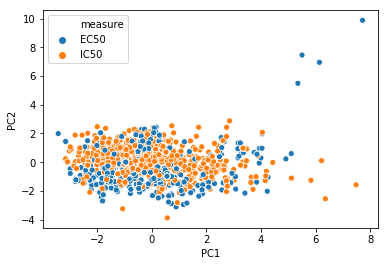

In [61]:
seaborn.scatterplot(x=CB1_t["PC1"], y=CB1_t["PC2"], hue=CB1_t["measure"])

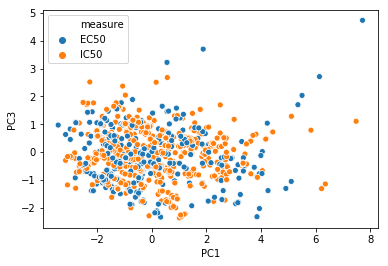

In [63]:
seaborn.scatterplot(x=CB1_t["PC1"], y=CB1_t["PC3"], hue=CB1_t["measure"])

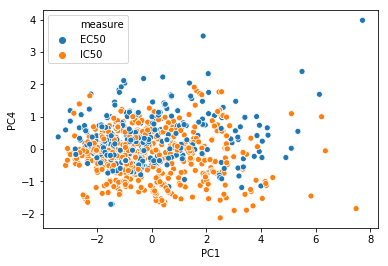

In [64]:
seaborn.scatterplot(x=CB1_t["PC1"], y=CB1_t["PC4"], hue=CB1_t["measure"])

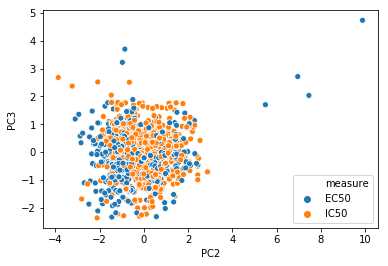

In [65]:
seaborn.scatterplot(x=CB1_t["PC2"], y=CB1_t["PC3"], hue=CB1_t["measure"])

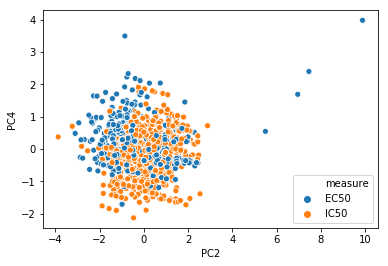

In [66]:
seaborn.scatterplot(x=CB1_t["PC2"], y=CB1_t["PC4"], hue=CB1_t["measure"])

# MDS

In [67]:
CB1_fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=1024) for m in CB1_clean]

In [68]:
sparse_mat = distance.pdist(CB1_fps, metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

In [71]:
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
CB1_mds = clf.fit_transform(dist_mat)

In [74]:
CB1_mds_res = pd.DataFrame(CB1_mds, columns=["x","y"])
CB1_mds_res["measure"] = CB1_measure

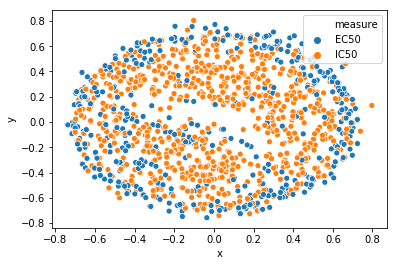

In [75]:
seaborn.scatterplot(x="x", y="y", data=CB1_mds_res, hue="measure")

# Model

In [122]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.ticker as ticker
import math

In [93]:
data = pd.DataFrame()
data["Molecule"] = CB1_mols
data["pChEMBL Value"] = CB1_value
data["FPS"] = [Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in data["Molecule"]]
data[:5]

,Molecule,pChEMBL Value,FPS
0,<rdkit.Chem.rdchem.Mol object at 0x7f3d5ad54d00>,7.4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,<rdkit.Chem.rdchem.Mol object at 0x7f3d5ad54940>,7.7,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,<rdkit.Chem.rdchem.Mol object at 0x7f3d5b3eaee0>,8.21,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ..."
3,<rdkit.Chem.rdchem.Mol object at 0x7f3d5ade2170>,8,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,<rdkit.Chem.rdchem.Mol object at 0x7f3d5ad547b0>,8.46,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [94]:
train, test = train_test_split(data) #75/25

In [135]:
rfr = RandomForestRegressor(n_estimators=25, max_depth=5)
rfr.fit(list(train["FPS"]), list(train["pChEMBL Value"]))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [136]:
test["Predicted value"] = rfr.predict(list(test["FPS"]))

/home/anna/miniconda2/envs/pnl/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [137]:
test[:5]

,Molecule,pChEMBL Value,FPS,Predicted value
808,<rdkit.Chem.rdchem.Mol object at 0x7f3d5ad239e0>,7.92,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.010962
995,<rdkit.Chem.rdchem.Mol object at 0x7f3d5ad275d0>,7.75,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.841332
367,<rdkit.Chem.rdchem.Mol object at 0x7f3d5ad1acb0>,7.25,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.733239
730,<rdkit.Chem.rdchem.Mol object at 0x7f3d5ad22120>,9.27,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.169130
759,<rdkit.Chem.rdchem.Mol object at 0x7f3d5ad22a30>,9.66,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.272489


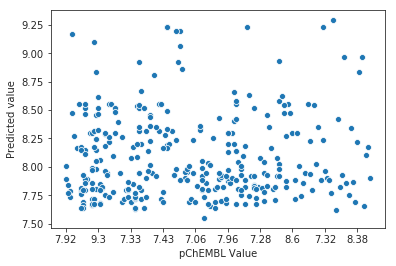

In [138]:
p = seaborn.scatterplot(x="pChEMBL Value", y="Predicted value", data=test)
p.xaxis.set_major_locator(ticker.MultipleLocator(15))

In [139]:
score = r2_score(y_true=test["pChEMBL Value"], y_pred=test["Predicted value"])
mse = mean_squared_error(y_true=test["pChEMBL Value"], y_pred=test["Predicted value"])
score, math.sqrt(mse)

(0.37325498069494545, 0.5693021208334272)

In [140]:
train["Predicted value"] = rfr.predict(list(train["FPS"]))

/home/anna/miniconda2/envs/pnl/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


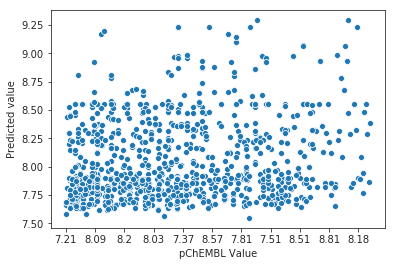

In [141]:
p=seaborn.scatterplot(x="pChEMBL Value", y="Predicted value", data=train)
p.xaxis.set_major_locator(ticker.MultipleLocator(20))

In [142]:
score = r2_score(y_true=train["pChEMBL Value"], y_pred=train["Predicted value"])
mse = mean_squared_error(y_true=train["pChEMBL Value"], y_pred=train["Predicted value"])
score, math.sqrt(mse)

(0.44590232576314437, 0.5099416679692271)